In [1]:
# Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition

fm = FailureMode(alpha=50, beta=1.5, gamma=10)

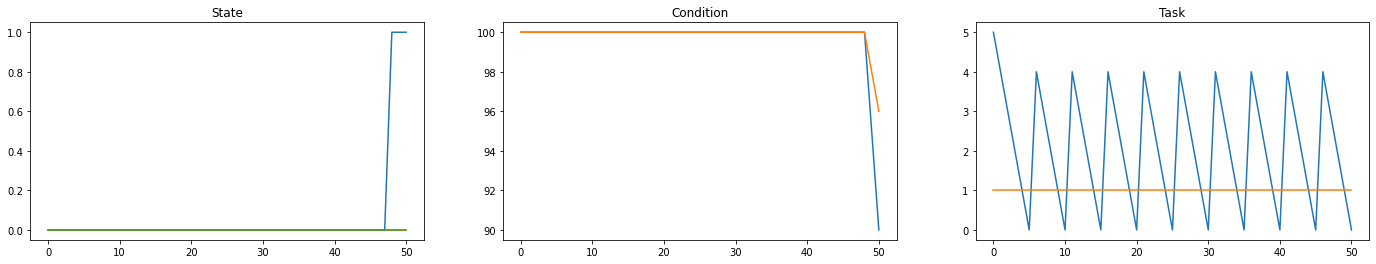

In [3]:
timeline = fm.init_timeline(50, 0)
fm.plot_timeline()

In [4]:
t_now = 0
t_end = 50

timeline = fm.init_timeline(t_start=t_now, t_end=t_end)

while t_now < t_end:
    print('sim %s ' %(t_now))

    # Check when the next task needs to be executed
    t_now, task_names = fm.next_tasks(timeline, t_now, t_end)

    for task_name in task_names:
        
        # Complete the tasks
        print('execute %s' %(task_name))
        states = fm.tasks[task_name].sim_completion(t_now, timeline=fm.timeline, states=fm.get_states(), conditions=fm.conditions)

        # Update timeline
        fm.set_states(states) # Change this to update timeline based on states that have changed
        fm.update_timeline(t_now, t_end, states)
    
    fm.plot_timeline()
    t_now = t_now + 1

sim 0 
execute inspection


TypeError: 'NoneType' object is not subscriptable

In [5]:
fm.timeline

{'time': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 'initiation': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True]),
 'wall_thickness': array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100.,  95.,  

In [6]:
t_start=t_now
t_end=t_end
states_to_update=states
conditions_to_update = dict()

# Check for initiation changes
if 'intiation' in states_to_update:
    timeline['initiation'][t_start:t_end] = np.full(t_end - t_start + 1, states_to_update['initiation'])
    t_initiate = t_start
    if states_to_update['initiation'] == False:
        t_initiate = min(t_end, int(fm.init_dist.sample()))
        timeline['initiation'][t_initiate:] = 1

# Check for condition changes
for condition in fm.conditions.values():
    if condition.name in conditions_to_update:
        timeline[condition.name][t_start:t_end] = condition.get_condition_profile(t_start=-t_initiate, t_stop=t_end - t_initiate)

# Check for detection changes
if 'detection' in states_to_update:
    timeline['detection'][t_start:t_end] = np.full(t_end - t_start + 1, states_to_update['detection'])

# Check for failure changes
if 'failure' in states_to_update:
    timeline['failure'] = np.full(t_end - t_start + 1, states_to_update['failed'])
    if states_to_update['failed'] == False:
        for condition in fm.conditions.values():
            tl_f = condition.sim_failure_timeline(t_start = - t_initiate, t_stop = t_end - t_initiate)
            timeline['failure'] = (timeline['failure']) | (tl_f)

NameError: name 't_now' is not defined

In [7]:
fm.conditions['wall_thickness'].set_condition(80)
fm.conditions['wall_thickness'].set_condition_profile()
fm.sim_timeline(100)
fm.plot_timeline()

NameError: name 'fm' is not defined

In [8]:
abc = fm.tasks['ocr'].sim_timeline(timeline=fm.sim_timeline(50), t_end = 50)

NameError: name 'fm' is not defined

In [9]:
abc = (~abc).astype(int)

NameError: name 'abc' is not defined

In [10]:
fm.next_tasks(timeline, 50)

NameError: name 'fm' is not defined

In [11]:
time = np.array(1)

In [12]:
time[10:30] = 'a'

IndexError: too many indices for array

In [13]:
class parent():

    def __init__(self):

        self.val = 'parent'

    def get_val(self):

        if self.age == 'old':
            self.get_old_val()
        else:
            self.get_young_val()

class child_old(parent):
    
    def __init__(self):
        
        self.val = 'child'
        self.age = 'old'

    def get_old_val(self):
        print (self.age, self.val)

class child_young(parent):

    def __init__(self):

        self.val = 'child'
        self.age = 'young'

    def get_young_val(self):

        print (self.age, self.val)

In [14]:
yng = child_young()
par = parent()

In [17]:
yng.get_val()
par.get_val()

young child


AttributeError: 'parent' object has no attribute 'age'

In [16]:
yng